## **Join reviews data with item metadata**

In [1]:
# Import packages
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.sparse import csr_matrix
#
from contextlib import redirect_stdout


In [2]:
# Set display option to show full content of columns
pd.options.display.max_colwidth = None

# Turn off scientific notation for pandas DataFrames
pd.options.display.float_format = '{:.2f}'.format

In [3]:
# Take the dataframes
# file_reviews = '/content/drive/MyDrive/Recommendation Engine BP/Home_and_Kitchen_filtered.csv'
file_reviews = '../data/Home_and_Kitchen_filtered.csv'
df_reviews = pd.read_csv(file_reviews)

file_items = '../data/meta_Home_and_Kitchen_filtered.csv'
df_items = pd.read_csv(file_items)

/var/folders/86/_khp3pb10vg5vtbr6fmndrxc0000gn/T/ipykernel_77489/1682365163.py:4: DtypeWarning: Columns (0: vote) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reviews = pd.read_csv(file_reviews)


In [4]:
# Merge reviews with items using left_join
df_combined = df_reviews.merge(df_items, left_on='asin', right_on='asin', how = 'left')

# Convert 'unixReviewTime' to datetime format
df_combined['unixReviewTime'] = pd.to_datetime(df_combined['unixReviewTime'], unit='s')

In [15]:
def df_information(df):
    """
    Returns essential information about a pandas DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        dict: A dictionary containing:
              - 'shape': tuple of (rows, columns)
              - 'info': string output of df.info()
              - 'numerical_summary': summary statistics for numerical columns
              - 'numerical_cols': list of numerical column names
              - 'categorical_cols': list of categorical/object column names
              - 'missing_values': Series of missing values sorted descending
              - 'Number of Duplicates': count of duplicate rows
    """
    info = {}

    # 1. Shape of the DataFrame
    info['shape'] = df.shape

    # 2. General information (like df.info())
    f = io.StringIO()
    with redirect_stdout(f):
        df.info(verbose=True, show_counts=True)
    info['info'] = f.getvalue()

    # 3. Summary Statistics for numerical columns
    info['numerical_summary'] = df.describe()

    # 4. Identify Numerical and Categorical Variables
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    info['numerical_cols'] = numerical_cols
    info['categorical_cols'] = categorical_cols

    # 5. Missing Values
    missing_values = df.isnull().sum()
    info['missing_values'] = missing_values.sort_values(ascending=False)

    # 6. Number of Duplicates
    info['duplicates'] = df.duplicated().sum()

    return info

In [6]:
df_info = df_information(df_combined)

In [7]:
# Check the df_info
for i in df_info.keys():
  print(f"{i}:\n{df_info[i]}\n")

shape:
(7244644, 19)

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7244644 entries, 0 to 7244643
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   overall         7244644 non-null  float64       
 1   verified        7244644 non-null  bool          
 2   reviewTime      7244644 non-null  object        
 3   reviewerID      7244644 non-null  object        
 4   asin            7244644 non-null  object        
 5   reviewerName    7243371 non-null  object        
 6   summary         7243239 non-null  object        
 7   unixReviewTime  7244644 non-null  datetime64[ns]
 8   vote            1006041 non-null  object        
 9   style           4498971 non-null  object        
 10  image           195269 non-null   object        
 11  category        7234645 non-null  object        
 12  description     7234645 non-null  object        
 13  title           7234620 non-null  object    

In [8]:
# Check for different combinations for missing values
df_combined[(df_combined['rank'].isnull() == True) &
            (df_combined['description'].isnull() == False)]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,summary,unixReviewTime,vote,style,image,category,description,title,brand,feature,rank,main_cat,price


In [9]:
# Drop duplicate rows from df_combined
df_combined.drop_duplicates(inplace=True)

**General Summary**

*   Data has **7.2M rows and 18 columns**
*   Data has 1 **numerical** variable (rating). The rest are **categorical** variables.
*   The **reviews** are skewed to high, with 25 percentile being 4 or above.
*   We have aound **570k duplicates**. This can be because we removed the reviewText variable (probably a user wrote multiple reviews)
*   Variables **"category", "description", "rank", and "feature"** are always missing together







## **Analysis with Subset**

**Purpuse**
Since for the basic modeling we do not need **context information (e.g., style, category)**, we will take the 3 variables for the current analysis: **userId, rating, time**.

In [5]:
# Print the 1st row
display(df_combined.loc[0])

overall                                                                                                                                                                                                                                                                                                                                                                                                                                             5.00
verified                                                                                                                                                                                                                                                                                                                                                                                                                                            True
reviewTime                                                                                                            

In [6]:
# Take the subset to analys
df_subset = df_combined[['overall', 'reviewerID', 'asin', 'unixReviewTime']]
df_subset.drop_duplicates(inplace=True)

In [7]:
# Check number of rows and number of unique reviewers

print(f'Number of total rows:', df_subset.shape[0])
print(f'Number of total reviewerIDs', df_subset['reviewerID'].nunique())

Number of total rows: 6646597
Number of total reviewerIDs 777242


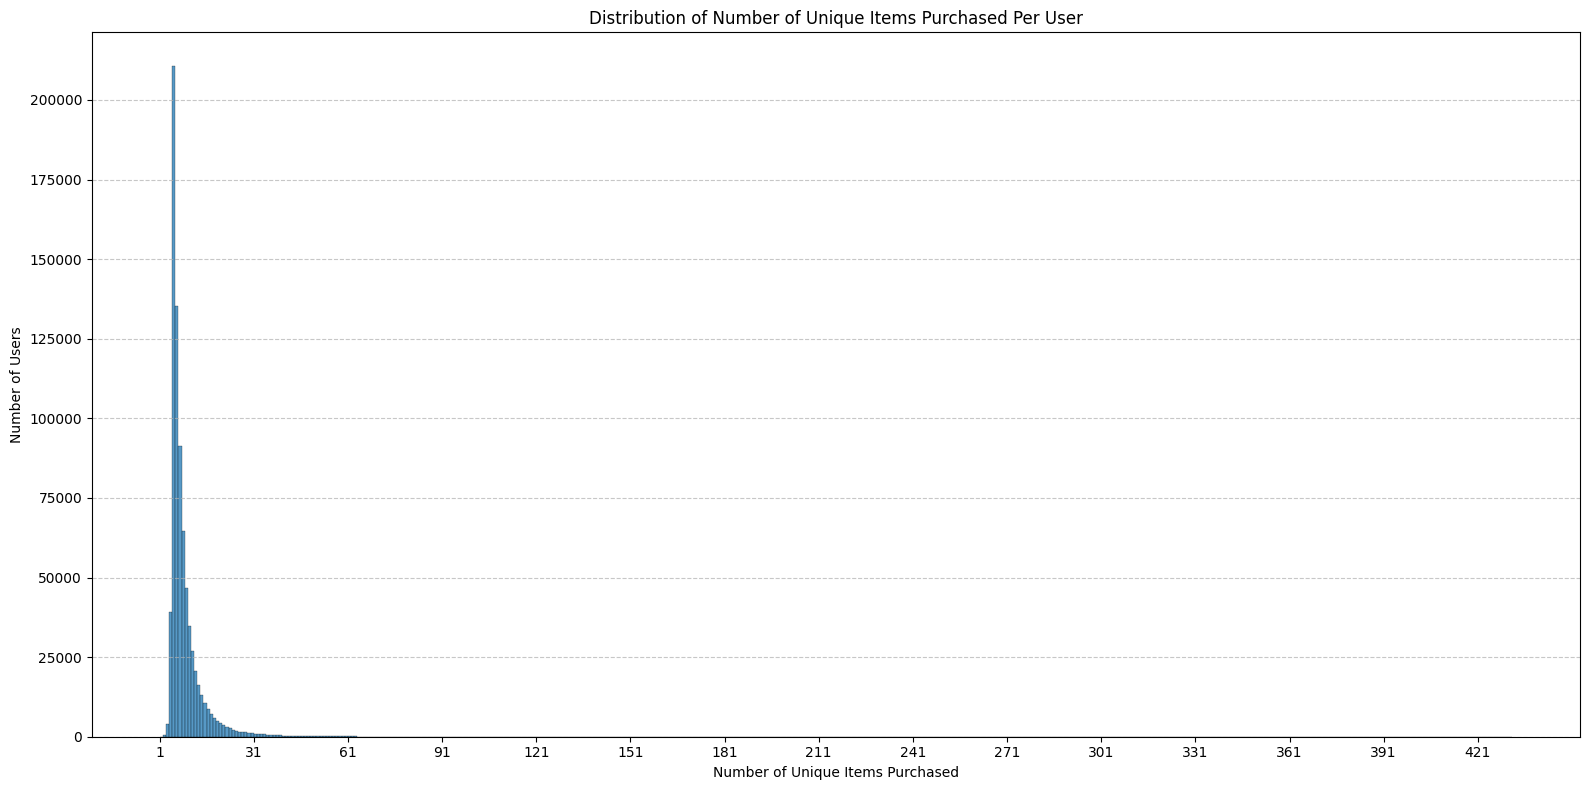

In [13]:
# Count the number of unique items (asin) purchased by each user (reviewerID)
items_per_user = df_subset.groupby('reviewerID')['asin'].nunique()

# Create a histogram of the distribution of items purchased per user
plt.figure(figsize=(16, 8))
sns.histplot(items_per_user, bins=range(1, items_per_user.max() + 2), kde=False)
plt.title('Distribution of Number of Unique Items Purchased Per User')
plt.xlabel('Number of Unique Items Purchased')
plt.ylabel('Number of Users')

# Get current x-axis limits and generate ticks for every 10th value
max_items = items_per_user.max()
plt.xticks(range(1, max_items + 1, 30))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
# Distribution of number of items rated
items_per_user.describe()

count   777242.00
mean         8.53
std          7.04
min          1.00
25%          5.00
50%          6.00
75%          9.00
max        431.00
Name: asin, dtype: float64

In [15]:
# This counts how many users bought 1 item, how many bought 2 items, etc.
users_by_items_purchased = items_per_user.value_counts().sort_index()

# Convert to DataFrame for better display
df_users_by_items = users_by_items_purchased.reset_index()
df_users_by_items.columns = ['Number of Unique Items Purchased', 'Number of Users']


df_users_by_items.sort_values(['Number of Users'], ascending=False).head(10)

,Number of Unique Items Purchased,Number of Users
4,5,210717
5,6,135427
6,7,91459
7,8,64590
8,9,46748
3,4,39180
9,10,34879
10,11,26847
11,12,20687
12,13,16170


In [16]:
# Number of reviews by user
items_per_user.sort_values(ascending=False)

reviewerID
AVU1ILDDYW301     431
A23GFTVIETX7DS    350
A3AZI828WJN1CD    347
A2R1HUYHXV7H18    345
A2GP4EJIAA2OE0    337
                 ... 
A2DJFIWDKOCPBY      1
AG7X98O6F9W04       1
A7V6ACKW0Y3HQ       1
A2DVKA2HD9LQK7      1
A1TNCUK7ZTI4FB      1
Name: asin, Length: 777242, dtype: int64

/var/folders/wp/mbxlfymj4fg9dwsmpnqs92x80000gn/T/ipykernel_16523/247613833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['review_year'] = df_subset['unixReviewTime'].dt.year


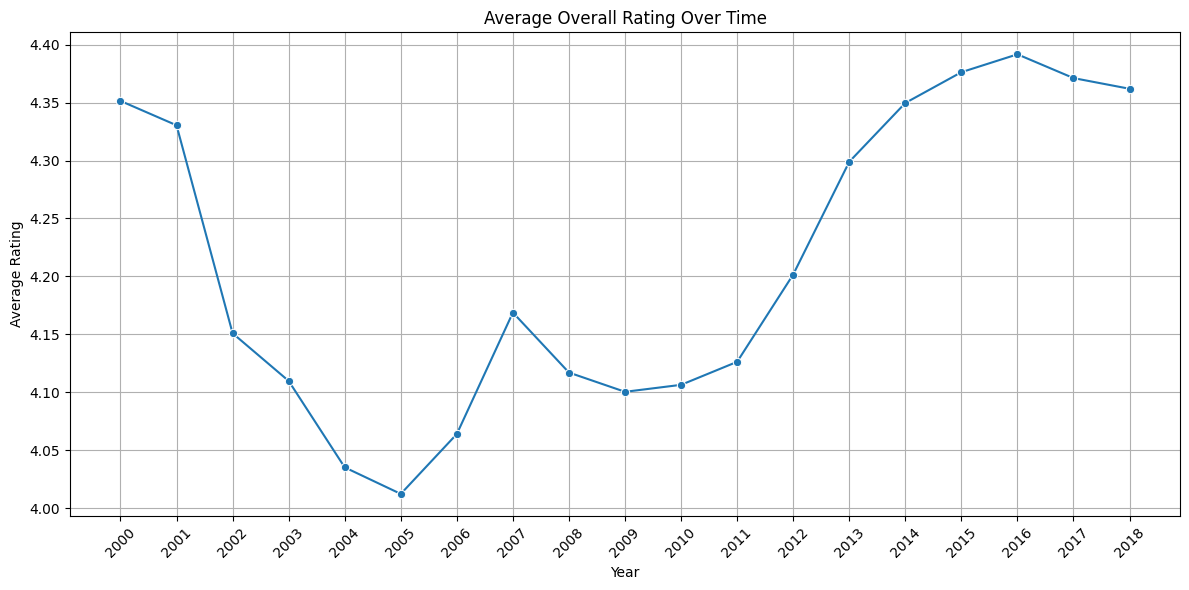

In [17]:
# Visualize average rating over time
# # Extract year from reviewTime for time-based analysis
df_subset['review_year'] = df_subset['unixReviewTime'].dt.year

# 1. Average Rating Over Time
average_ratings_by_year = df_subset.groupby('review_year')['overall'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='review_year', y='overall', data=average_ratings_by_year, marker='o')
plt.title('Average Overall Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
# Set x-ticks to display integer years
plt.xticks(average_ratings_by_year['review_year'].unique(), rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

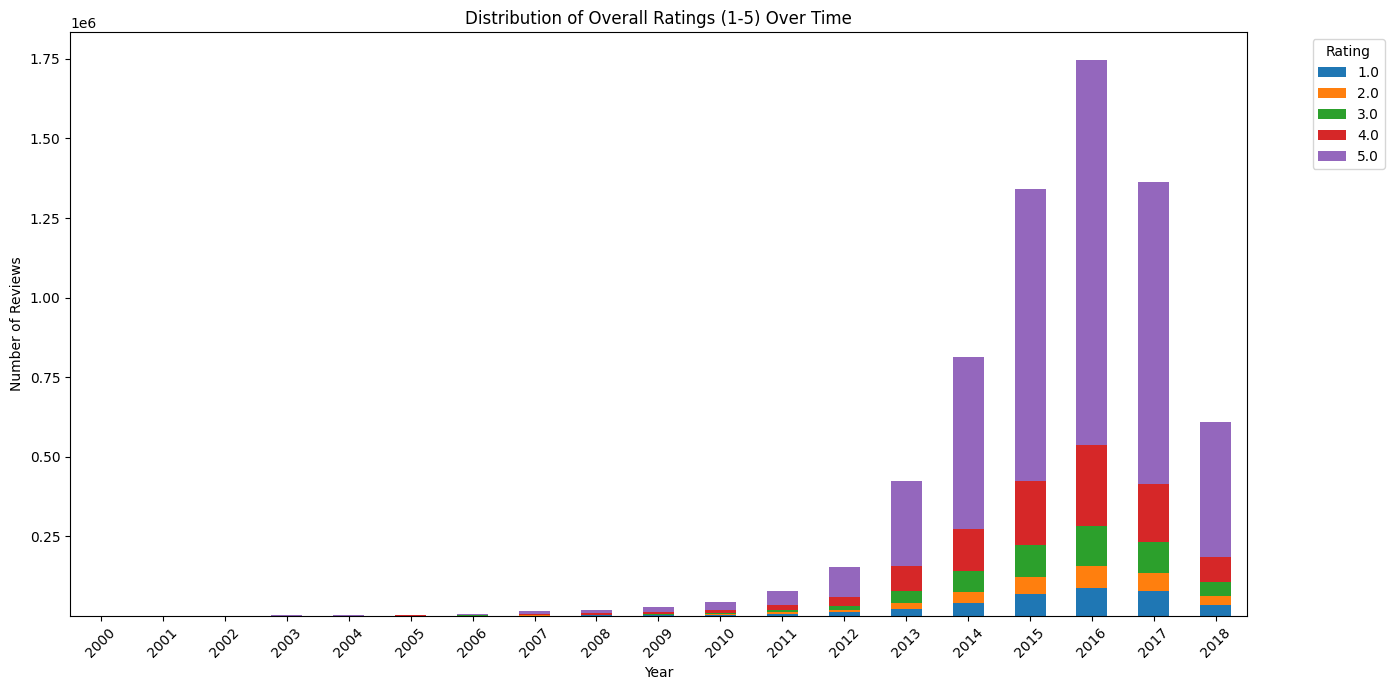

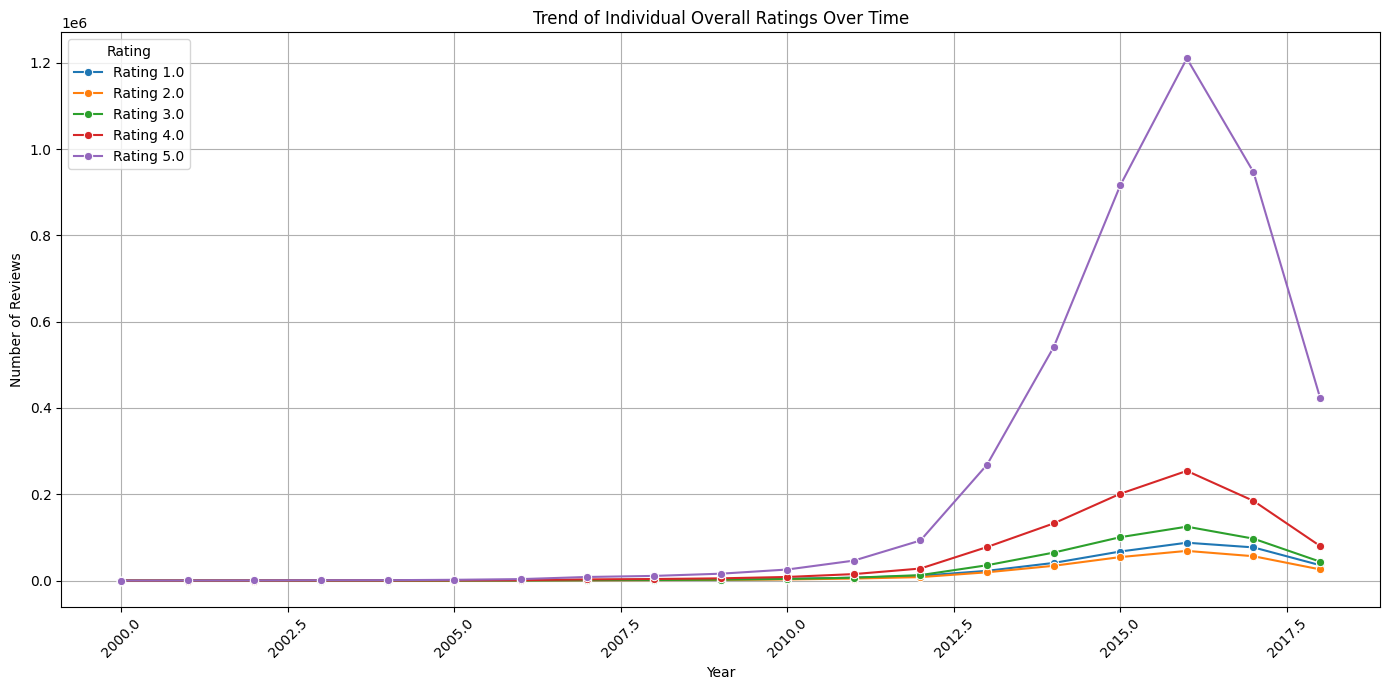

In [18]:
# 2. Distribution of Each Rating (1-5) Over Time
# Count occurrences of each rating per year
rating_distribution_by_year = df_subset.groupby(['review_year', 'overall']).size().unstack(fill_value=0)

# Plotting the distribution as a stacked bar chart or separate lines
plt.figure(figsize=(14, 7))
rating_distribution_by_year.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Distribution of Overall Ratings (1-5) Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Alternatively, as separate line plots for clearer trends of each rating
plt.figure(figsize=(14, 7))
for rating in sorted(df_subset['overall'].unique()):
    sns.lineplot(x=rating_distribution_by_year.index, y=rating_distribution_by_year[rating], label=f'Rating {rating}', marker='o')

plt.title('Trend of Individual Overall Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='Rating')
plt.tight_layout()
plt.show()

## **Create functions for model evaluation**

**Example**
We consider 2 users with **top-5 recommended items**:

- User 1 purchased items `{A, C}`  
- User 2 purchased items `{B}`  
- Recommendations for both users (top-5): `[A, B, C, D, E]`

---

| Metric | Formula | Description | Example (2 users, 5 recommended items) |
|--------|---------|-------------|----------------------------------------|
| **Precision@K** | $$\text{Precision@K}_u = \frac{|R_u^K \cap P_u|}{K}$$ | Fraction of top-K recommended items that were actually purchased. In other words, TP/(TP+TN). If we recommend 5 items, and user later purchased 2 out of 5, then the precision is 2/5 = 0.4. The final is the average of all the precision scores for all the users.| **User 1:** 2/5 = 0.4 <br> **User 2:** 1/5 = 0.2 <br> **Average:** (0.4 + 0.2)/2 = 0.3 |
| **Recall@K** | $$\text{Recall@K}_u = \frac{|R_u^K \cap P_u|}{|P_u|}$$ | Fraction of all purchased items that appear in top-K recommendations. In other words, TP/(TP + FN). If the user purchased 3 items after we make the recommendations and out of the 3, 2 were in the list of 5 products that we recommended, then the recall is 2/3 = 0.66. The final is the average of all the precisions scores for all the users.| **User 1:** 2/2 = 1.0 <br> **User 2:** 1/1 = 1.0 <br> **Average:** (1.0 + 1.0)/2 = 1.0 |
| **Hit@K** | $$\text{Hit@K}_u = \begin{cases} 1 & \text{if } |R_u^K \cap P_u| \ge 1 \\ 0 & \text{otherwise} \end{cases}$$ | Binary metric: Did the user get **at least one relevant item** in the top-K? For example, if out of 5 items recommend the user later purchased >= 1, then the hit rate is 1 for that user (0 otherwise). The total hit rate is the avearege of all the hit rates for the user. | **User 1:** 1 <br> **User 2:** 0 (none of the recommended items were purhcased) <br> **Average:** (1+0)/2 = 0.5 |
| **DCG@K** | $$DCG@K = \sum_{i=1}^{K} \frac{rel_i}{\log_2(i+1)}$$ | Discounted Cumulative Gain measures **ranking quality**, giving more weight to relevant items appearing at the top. The matric is used to calculate **NDCG@k**. For example, if the order of items recommende is [A, B, C, D, E] and the user later purchased [A, C], then DCG@K equals 1/log2(2) + 0/log2(3) + 1/log2(4)... = 1.5| **User 1:** relevance `[1,0,1,0,0]` → DCG = 1/1 + 0 + 1/2 = 1.5 <br> **User 2:** relevance `[0,1,0,0,0]` → DCG = 1/1.585 ≈ 0.63 |
| **IDCG@K** | $$IDCG@K = \sum_{i=1}^{|P_u|} \frac{1}{\log_2(i+1)}$$ | Ideal DCG: maximum possible DCG if all purchased items are ranked at the top. Again, is used to calculade NDCG@k. It calculates the best possible scenario based on the user's purchases. For example, since the user pruchased [A, C] the ideal recommendation would have been [A, C, _, _, _] and the ideal value would have been 1/log2(2) + 1/log2(3) = 1.63| **User 1:** 2 items purchased → IDCG = 1/1 + 1/1.585 ≈ 1 + 0.63 = 1.63 <br> **User 2:** 1 item purchased → IDCG = 1/1 = 1 |
| **NDCG@K** | $$NDCG@K = \frac{DCG@K}{IDCG@K}$$ | Normalized DCG: rank-aware metric (0–1). Rewards having relevant items **near the top**. Is calculated by DCG@k/IDCG@K and from the example above equals to 1.5/1.63 = 0.92| **User 1:** 1.5 / 1.63 ≈ 0.92 <br> **User 2:** 0.63 / 1 ≈ 0.63 <br> **Average:** (0.92+0.63)/2 ≈ 0.775 |

## **Test Model Performance**

In [21]:
### Importing the functions
import sys
from pathlib import Path

# Add project root to path
sys.path.append(str(Path().resolve().parent))
import functions.rs_baseline_models as rsbm
import functions.rs_evaluation as rseval

In [22]:
user_id = 'A8LUWTIPU9CZB'
cutoff_time = timestamp=pd.Timestamp('2016-11-05')

Test performance of the **most popular item** recommendation on a single user

In [23]:
# Check most popular items before the cutoff date recommende to the user
items_recommended = rsbm.get_topn_popular_items(df_subset,
                                           user_id,
                                           cutoff_time,
                                           n=20)
items_recommended

['B00FLYWNYQ',
 'B00COK3FD8',
 'B00902X68W',
 'B00NX47YP4',
 'B000M8YMEU',
 'B007WQ9YNE',
 'B000YGEVMI',
 'B000VENLF6',
 'B000BWZ7QO',
 'B00JVLG2KG',
 'B002S52ZDU',
 'B0091YYUAM',
 'B002KAPNA0',
 'B0015TMHSI',
 'B009HVH4XO',
 'B014P3B7TU',
 'B00AYULZEQ',
 'B00009R66F',
 'B00ARQVLGO',
 'B00EQT70QS']

In [24]:
# Check the actual items that the user purchased after the cutoff date
items_purchased = rsbm.get_items_purchased_after_cutoff(df_subset,
                                                   user_id,
                                                   cutoff_time)
items_purchased

['B004UC0GIU', 'B00R3Z4CWC', 'B00R9WRM4Y', 'B01DCG3WR6']

In [25]:
# For most popular items, calculate precision, recall, hit and dcg for the user

print(f'Precision@k', rseval.calculate_precision_at_k(items_recommended, items_purchased, 3))
print(f'Recall@k', rseval.calculate_recall_at_k(items_recommended, items_purchased, 3))
print(f'Hit@k', rseval.calculate_hit_at_k(items_recommended, items_purchased, 3))
print(f'NDSG@k', rseval.calculate_ndcg_at_k(items_recommended, items_purchased, 3))

Precision@k 0.0
Recall@k 0.0
Hit@k 0
NDSG@k 0.0


Test performance of **co occurrence recommendation** on a single user

In [26]:
items_recommended_cooccur = rsbm.cooccurrence_recommend_for_user_at_time(df_subset,
                                                                    user_id,
                                                                    cutoff_time)
items_recommended_cooccur

['B002J4BWV6', 'B00BCQ4D9A', 'B002FOFFW2', 'B009ZHYTPQ', 'B005S2KUEQ']

In [25]:
# For co occured items, calculate precision, recall, hit and dcg for the user

print(f'Precision@k', rseval.calculate_precision_at_k(items_recommended_cooccur, items_purchased, 3))
print(f'Recall@k', rseval.calculate_recall_at_k(items_recommended_cooccur, items_purchased, 3))
print(f'Hit@k', rseval.calculate_hit_at_k(items_recommended_cooccur, items_purchased, 3))
print(f'NDSG@k', rseval.calculate_ndcg_at_k(items_recommended_cooccur, items_purchased, 3))

Precision@k 0.0
Recall@k 0.0
Hit@k 0
NDSG@k 0.0


## Trending/Recently added
Let's think through how we want to define these products

In [27]:
rsbm.get_topn_trending_items(df_subset, user_id, timestamp, n=10)

['B01G5LGEUC',
 'B01DF4JQL6',
 'B013BYXBHK',
 'B01G5LGHJK',
 'B01BZPU5E4',
 'B01FSC4AGE',
 'B01G5LGEU2',
 'B00QYOF6CS',
 'B01AE35LJ2',
 'B004LQ1RKQ']

## **Test Item-Item Knn**

In [8]:
import functions.interaction_matrix as interaction_matrix
import functions.item_item_knn as iiknn


In [9]:
# --- Example to test ---
user_id = 'A8LUWTIPU9CZB'
cutoff_time = timestamp=pd.Timestamp('2016-11-05')


In [10]:
# Initialize matrix builder and knn
builder = interaction_matrix.InteractionMatrixBuilder(min_users=5, cutoff_time=cutoff_time)
matrix = builder.build(df_subset)


knn = iiknn.ItemItemRecommenderKnn(k=50, shrinkage=10)
knn.fit(matrix, builder.item_map, builder.items)

In [11]:
# # --- GET USER HISTORY BEFORE CUTOFF ---
user_history = df_subset[
    (df_subset['reviewerID'] == user_id) & (df_subset['unixReviewTime'] < cutoff_time)
]['asin'].unique().tolist()
user_history


['0560467893', 'B001F7SGHQ', 'B00AERTP4Q', 'B00TI17ED8', 'B011BVXH1U']

In [12]:
# --- GET RECOMMENDATIONS ---
recs = knn.recommend(user_history, top_n=15)

print(f"Recommendations for {user_id}: {recs}")

Recommendations for A8LUWTIPU9CZB: ['B002J4BWV6', 'B006K2AYAS', 'B008KX8UW4', 'B00F0J3BJ8', 'B00FYOB0S8', 'B005S2KUEQ', 'B004KEKHMI', 'B001AT1I4C', 'B00LCFKO44', 'B00IANIU0G', 'B017QREKU0', 'B004Q9SCM4', 'B00K8FJVQ6', 'B00C4Y4EOS', 'B00BFE3TH6']
